# Seam carving

## By: Mustafa Yildirim

Seam carving is a procedure to resize images in a manner that preserves “important” image content. The general steps for seam carving are as follows:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import kornia

/usr/local/lib/python3.10/dist-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


torch.Size([1, 3, 1151, 1728])


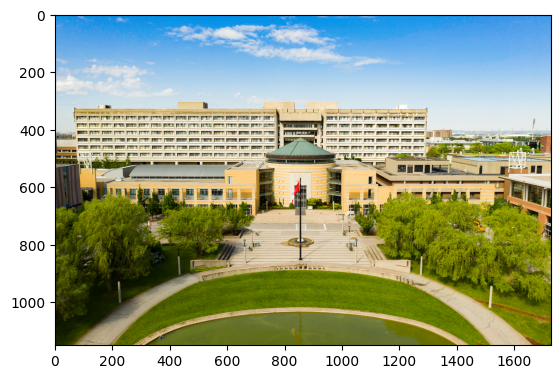

In [12]:
img_np3 = plt.imread('/content/York.jpg')
plt.imshow(img_np3)

img_np3 = img_np3.astype(np.float32) / 255.0

img_torch3 = torch.tensor(img_np3)
img_torch3 = img_torch3.permute(2, 0, 1)
img_torch3 = img_torch3.unsqueeze(0)
print(img_torch3.shape)

Computing the energy image, E, for the input image, e.g., the sum of the gradient magnitude images
computed for each of the three colour channels of the input image.

In [13]:
gradients = kornia.filters.SpatialGradient(mode='sobel')(img_torch3)
grad_x = gradients[:, :, 0, :, :]
grad_y = gradients[:, :, 1, :, :]

print(grad_x.shape)
print(grad_y.shape)

torch.Size([1, 3, 1151, 1728])
torch.Size([1, 3, 1151, 1728])


In [14]:
E_r = torch.sqrt(grad_x[:, 0, :, :]**2 + grad_y[:, 0, :, :]**2)
E_g = torch.sqrt(grad_x[:, 1, :, :]**2 + grad_y[:, 1, :, :]**2)
E_b = torch.sqrt(grad_x[:, 2, :, :]**2 + grad_y[:, 2, :, :]**2)

E = E_r + E_g + E_b

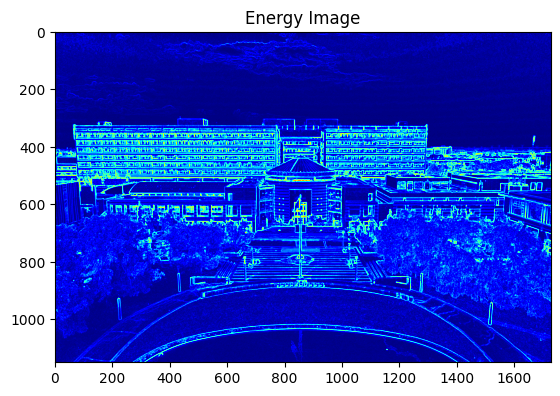

In [15]:
E_np = kornia.utils.tensor_to_image(E)

E_np = (E_np * 255.0).astype(np.uint8)

plt.imshow(E_np, cmap='jet')
plt.title("Energy Image")
plt.show()

Creating a scoring matrix, M, with spatial image dimensions matching those of the input image.

In [16]:
print("Image shape:", img_torch3.shape)

print("E shape:", E.shape)
C, H, W = E.shape

M = torch.zeros((H, W), dtype=torch.float32)

print("M shape:", M.shape)

Image shape: torch.Size([1, 3, 1151, 1728])
E shape: torch.Size([1, 1151, 1728])
M shape: torch.Size([1151, 1728])


Setting the values of the first row of the scoring matrix, M, to match those of the energy image, E.

In [17]:
E = E.squeeze(0)

print("E shape:", E.shape)

M[0, :] = E[0, :]

print("M: ", M)
print("E: ", E)

E shape: torch.Size([1151, 1728])
M:  tensor([[0.0201, 0.0226, 0.0467,  ..., 0.0390, 0.0326, 0.0550],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
E:  tensor([[0.0201, 0.0226, 0.0467,  ..., 0.0390, 0.0326, 0.0550],
        [0.0269, 0.0253, 0.0404,  ..., 0.0455, 0.0377, 0.0760],
        [0.0562, 0.0409, 0.0153,  ..., 0.0568, 0.0407, 0.0267],
        ...,
        [0.0180, 0.0170, 0.0242,  ..., 0.0199, 0.0176, 0.0401],
        [0.0280, 0.0193, 0.0253,  ..., 0.0066, 0.0162, 0.0178],
        [0.0200, 0.0191, 0.0233,  ..., 0.0297, 0.0239, 0.0219]])


Setting the values of every entry in the scoring matrix to the energy value at that position and the minimum
value in any of the neighbouring cells above it in the seam.

In [18]:
M_pad = torch.full((H, W + 2), float('inf'), dtype=torch.float32)
M_pad[:, 1:-1] = M

for i in range(1, H):
    # Getting the minimum of three neighbors using the padded matrix
    minimum = torch.min(torch.min(M_pad[i-1, :-2], M_pad[i-1, 1:-1]), M_pad[i-1, 2:])

    # Computing the minumum culminative energy
    M[i, :] = E[i, :] + minimum


In [19]:
print("scoring matrix M: ", M)

scoring matrix M:  tensor([[0.0201, 0.0226, 0.0467,  ..., 0.0390, 0.0326, 0.0550],
        [0.0470, 0.0453, 0.0630,  ..., 0.0679, 0.0703, 0.1086],
        [0.0562, 0.0409, 0.0153,  ..., 0.0568, 0.0407, 0.0267],
        ...,
        [0.0180, 0.0170, 0.0242,  ..., 0.0199, 0.0176, 0.0401],
        [0.0280, 0.0193, 0.0253,  ..., 0.0066, 0.0162, 0.0178],
        [0.0200, 0.0191, 0.0233,  ..., 0.0297, 0.0239, 0.0219]])


Finding the minimum value in the bottom row of the scoring matrix. 

The corresponding position of the minimal value is the bottom of the optimal seam.

In [20]:
last_row = M[H-1, :]
print(last_row.shape)
print(last_row)

# Getting the min value
min_val = torch.min(last_row)
print(min_val)

# Getting the position of the min value
min_val_pos = torch.argmin(last_row).item()
print(min_val_pos)

torch.Size([1728])
tensor([0.0200, 0.0191, 0.0233,  ..., 0.0297, 0.0239, 0.0219])
tensor(7.4506e-09)
1339


Using M[row, col] to trace back up the seam by following the smallest value in any of the neighbouring
positions above.

In [21]:
seam = [min_val_pos]

# Tracing back up the seam
for i in range(H-2, -1, -1):

  # Comparing the leftmost pixel with the 2 top neighbours
  if (min_val_pos == 0):
    next_min_pos = min_val_pos + torch.argmin(M[i, min_val_pos:min_val_pos+2]).item()

  # Comparing the righmost pixel with the 2 top neighbours
  elif (min_val_pos == W-1):
    next_min_pos = min_val_pos - 1 + torch.argmin(M[i, min_val_pos-1:min_val_pos+1]).item()

  # Comparing the pixels in between with the 3 top neighbours
  else:
    next_min_pos = min_val_pos - 1 + torch.argmin(M[i, min_val_pos-1:min_val_pos+2]).item()

  seam.append(next_min_pos)
  min_val_pos = next_min_pos

seam.reverse()

Removing the seam from the image.

In [22]:
B, C, H, W = img_torch3.shape

new_img = torch.zeros((B, C, H, W-1), dtype=img_torch3.dtype)

for i in range(H):
  new_img[:, :, i, :] = torch.cat((img_torch3[:, :, i, :seam[i]], img_torch3[:, :, i, seam[i]+1:]), dim=-1)

In [23]:
print("New image shape:", new_img.shape)

New image shape: torch.Size([1, 3, 1151, 1727])


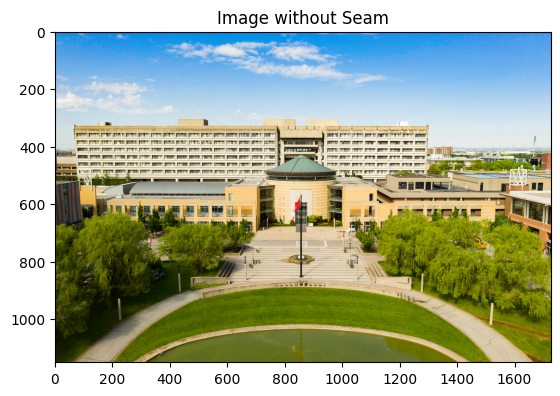

In [24]:
new_img_np = kornia.utils.tensor_to_image(new_img)

new_img_np = (new_img_np * 255.0).astype(np.uint8)

plt.imshow(new_img_np, cmap='gray')
plt.title("Image without Seam")
plt.show()

The MySeamCarving function resizes an image to a desired resolution by removing the necessary horizontal and vertical seams. It achieves this using a single helper function, CarvingHelper, which removes all required vertical (or horizontal) seams.

First, CarvingHelper is called to remove vertical (or horizontal) seams. Then, the resulting image is transposed, and the function is called again on the transposed image to remove the remaining horizontal (or vertical) seams.

In [25]:
def CarvingHelper(img, iter):
  B, C, H, W = img.shape

  # Part (h)
  for iteration in range(iter):

    # Part (a)
    gradients = kornia.filters.SpatialGradient(mode='sobel')(img)
    grad_x = gradients[:, :, 0, :, :]
    grad_y = gradients[:, :, 1, :, :]

    E_r = torch.sqrt(grad_x[:, 0, :, :]**2 + grad_y[:, 0, :, :]**2)
    E_g = torch.sqrt(grad_x[:, 1, :, :]**2 + grad_y[:, 1, :, :]**2)
    E_b = torch.sqrt(grad_x[:, 2, :, :]**2 + grad_y[:, 2, :, :]**2)

    E = E_r + E_g + E_b


    # Part (b)
    M = torch.zeros((H, W), dtype=torch.float32)


    # Part (c)
    E = E.squeeze(0)

    M[0, :] = E[0, :]

    # Part (d)
    M_pad = torch.full((H, W + 2), float('inf'), dtype=torch.float32)
    M_pad[:, 1:-1] = M

    for i in range(1, H):
        minimum = torch.min(torch.min(M_pad[i-1, :-2], M_pad[i-1, 1:-1]), M_pad[i-1, 2:])
        M[i, :] = E[i, :] + minimum


    # Part (e)
    last_row = M[H-1, :]
    min_val = torch.min(last_row)
    min_val_pos = torch.argmin(last_row).item()


    # Part (f)
    seam = [min_val_pos]

    for i in range(H-2, -1, -1):

      if (min_val_pos == 0):
        next_min_pos = min_val_pos + torch.argmin(M[i, min_val_pos:min_val_pos+2]).item()

      elif (min_val_pos == W-1):
        next_min_pos = min_val_pos - 1 + torch.argmin(M[i, min_val_pos-1:min_val_pos+1]).item()

      else:
        next_min_pos = min_val_pos - 1 + torch.argmin(M[i, min_val_pos-1:min_val_pos+2]).item()

      seam.append(next_min_pos)
      min_val_pos = next_min_pos

    seam.reverse()


    # Part (g)
    new_img = torch.zeros((B, C, H, W-1), dtype=img.dtype)

    for i in range(H):
      new_img[:, :, i, :] = torch.cat((img[:, :, i, :seam[i]], img[:, :, i, seam[i]+1:]), dim=-1)

    img = new_img
    W -= 1

  return img

In [26]:
def MySeamCarving(img, width, height):

  B, C, H, W = img.shape

  hor_seams = H - height
  ver_seams = W - width

  new_img = img.clone()

  # Removing vertical seams
  if (ver_seams >= 0):
    new_img = CarvingHelper(img, ver_seams)

  # Removing horizontal seams
  if (hor_seams >= 0):
    # Transpose
    new_img = new_img.permute(0, 1, 3, 2)
    new_img = CarvingHelper(new_img, hor_seams)
    # Transpose again
    new_img = new_img.permute(0, 1, 3, 2)


  return new_img

Testing the function on the image of YorkU

In [27]:
print("Initial Image Shape:", img_torch3.shape)

Initial Image Shape: torch.Size([1, 3, 1151, 1728])


In [28]:
height = 1151
width = 1200

resized_img = MySeamCarving(img_torch3, width, height)

Resized Image Shape: torch.Size([1, 3, 1151, 1200])


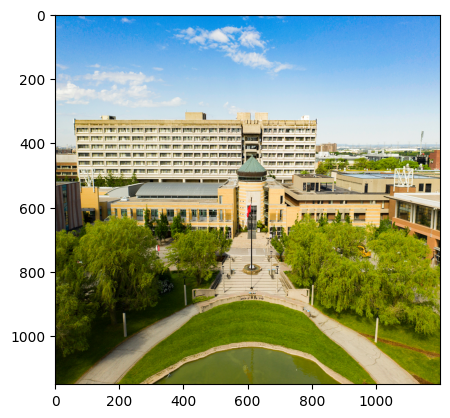

In [29]:
print("Resized Image Shape:", resized_img.shape)

resized_img_np = kornia.utils.tensor_to_image(resized_img)

resized_img_np = (resized_img_np * 255.0).astype(np.uint8)

plt.imshow(resized_img_np)
plt.show()

In [30]:
height = 720
width = 1728

resized_img2 = MySeamCarving(img_torch3, width, height)

Resized Image Shape: torch.Size([1, 3, 720, 1728])


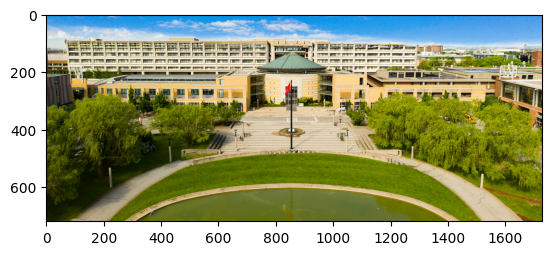

In [31]:
print("Resized Image Shape:", resized_img2.shape)

resized_img2_np = kornia.utils.tensor_to_image(resized_img2)

resized_img2_np = (resized_img2_np * 255.0).astype(np.uint8)

plt.imshow(resized_img2_np)
plt.show()

Testing the function on my image

torch.Size([1, 3, 564, 1024])


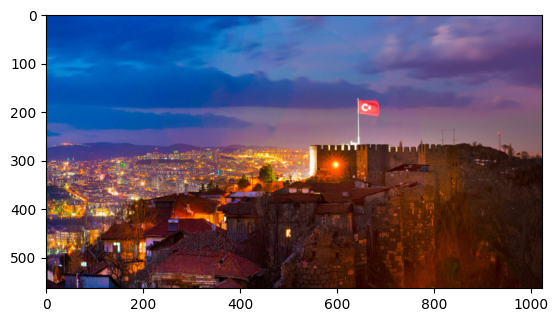

In [32]:
img_np4 = plt.imread('/content/city.jpg')
plt.imshow(img_np4)

img_np4 = img_np4.astype(np.float32) / 255.0

img_torch4 = torch.tensor(img_np4)
img_torch4 = img_torch4.permute(2, 0, 1)
img_torch4 = img_torch4.unsqueeze(0)
print(img_torch4.shape)

Resized Image Shape: torch.Size([1, 3, 300, 1024])


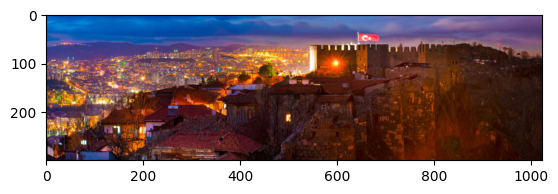

In [33]:
height = 300
width = 1024

resized_img5 = MySeamCarving(img_torch4, width, height)

print("Resized Image Shape:", resized_img5.shape)

resized_img5_np = kornia.utils.tensor_to_image(resized_img5)

resized_img5_np = (resized_img5_np * 255.0).astype(np.uint8)

plt.imshow(resized_img5_np)
plt.show()

Resized Image Shape: torch.Size([1, 3, 564, 700])


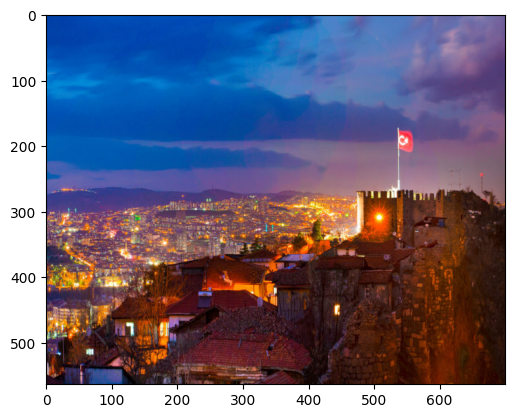

In [34]:
height = 564
width = 700

resized_img6 = MySeamCarving(img_torch4, width, height)

print("Resized Image Shape:", resized_img6.shape)

resized_img6_np = kornia.utils.tensor_to_image(resized_img6)

resized_img6_np = (resized_img6_np * 255.0).astype(np.uint8)

plt.imshow(resized_img6_np)
plt.show()

Implementing image expansion by inserting seams.


In [35]:
def CarvingHelper2(img, iter):
  B, C, H, W = img.shape

  # Part (h)
  for iteration in range(iter):

    # Part (a)
    gradients = kornia.filters.SpatialGradient(mode='sobel')(img)
    grad_x = gradients[:, :, 0, :, :]
    grad_y = gradients[:, :, 1, :, :]

    E_r = torch.sqrt(grad_x[:, 0, :, :]**2 + grad_y[:, 0, :, :]**2)
    E_g = torch.sqrt(grad_x[:, 1, :, :]**2 + grad_y[:, 1, :, :]**2)
    E_b = torch.sqrt(grad_x[:, 2, :, :]**2 + grad_y[:, 2, :, :]**2)

    E = E_r + E_g + E_b

    # Part (b)
    M = torch.zeros((H, W), dtype=torch.float32)

    # Part (c)
    E = E.squeeze(0)

    M[0, :] = E[0, :]

    # Part (d)
    M_pad = torch.full((H, W + 2), float('inf'), dtype=torch.float32)
    M_pad[:, 1:-1] = M

    for i in range(1, H):
        minimum = torch.min(torch.min(M_pad[i-1, :-2], M_pad[i-1, 1:-1]), M_pad[i-1, 2:])
        M[i, :] = E[i, :] + minimum


    # Part (e)
    last_row = M[H-1, :]
    min_val = torch.min(last_row)
    min_val_pos = torch.argmin(last_row).item()


    # Part (f)
    seam = [min_val_pos]

    for i in range(H-2, -1, -1):

      if (min_val_pos == 0):
        next_min_pos = min_val_pos + torch.argmin(M[i, min_val_pos:min_val_pos+2]).item()

      elif (min_val_pos == W-1):
        next_min_pos = min_val_pos - 1 + torch.argmin(M[i, min_val_pos-1:min_val_pos+1]).item()

      else:
        next_min_pos = min_val_pos - 1 + torch.argmin(M[i, min_val_pos-1:min_val_pos+2]).item()

      seam.append(next_min_pos)
      min_val_pos = next_min_pos

    seam.reverse()


    # Updated Part (g)
    new_img = torch.zeros((B, C, H, W+1), dtype=img.dtype)

    for i in range(H):
      new_img[:, :, i, :seam[i]] = img[:, :, i, :seam[i]]

      if (0 < seam[i] < W - 1):
        # Averaging the seam that is in the middle part with both its left and right neighbors
        new_img[:, :, i, seam[i]] = ((img[:, :, i, seam[i] - 1] + img[:, :, i, seam[i]] + img[:, :, i, seam[i] + 1])) / 3

      elif (seam[i] == 0):
        # Averaging the leftmost seam with only the right neighbor
        new_img[:, :, i, seam[i]] = ((img[:, :, i, seam[i]] + img[:, :, i, seam[i] + 1])) / 2

      elif (seam[i] == W - 1):
        # Averaging the righmost seam with only the left neighbor
        new_img[:, :, i, seam[i]] = ((img[:, :, i, seam[i]] + img[:, :, i, seam[i] - 1])) / 2


      # Shifting the remaining part after the seam
      new_img[:, :, i, seam[i] + 1:] = img[:, :, i, seam[i]:]

    img = new_img
    W += 1

  return img

In [36]:
def MySeamCarvingUpdated(img, width, height):

  B, C, H, W = img.shape

  hor_seams = H - height
  ver_seams = W - width

  new_img = img.clone()

  # Removing  or adding vertical seams
  if (ver_seams >= 0):
    new_img = CarvingHelper(img, ver_seams)

  elif (ver_seams < 0):
    ver_seams2 = abs(ver_seams)
    new_img = CarvingHelper2(img, ver_seams2)

  # Removing or adding horizontal seams
  if (hor_seams >= 0):
    new_img = new_img.permute(0, 1, 3, 2)
    new_img = CarvingHelper(new_img, hor_seams)
    new_img = new_img.permute(0, 1, 3, 2)

  elif (hor_seams < 0):
    hor_seams2 = abs(hor_seams)
    new_img = new_img.permute(0, 1, 3, 2)
    new_img = CarvingHelper2(new_img, hor_seams2)
    new_img = new_img.permute(0, 1, 3, 2)


  return new_img

Testing the function on the image of YorkU

In [37]:
# initial height: 1151, width: 1728

height = 1151
width = 1790

resized_img3 = MySeamCarvingUpdated(img_torch3, width, height)

Resized Image Shape: torch.Size([1, 3, 1151, 1790])


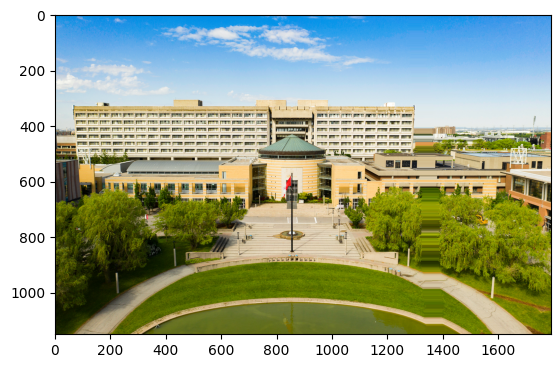

In [38]:
print("Resized Image Shape:", resized_img3.shape)


resized_img3_np = kornia.utils.tensor_to_image(resized_img3)

resized_img3_np = (resized_img3_np * 255.0).astype(np.uint8)

plt.imshow(resized_img3_np)
plt.show()

In [39]:
# initial height: 1151, width: 1728

height = 1200
width = 1728

resized_img4 = MySeamCarvingUpdated(img_torch3, width, height)

Resized Image Shape: torch.Size([1, 3, 1200, 1728])


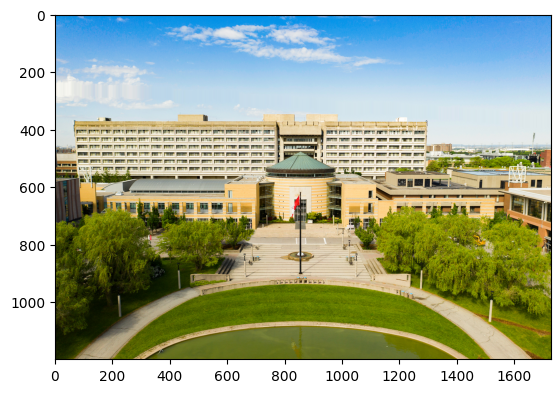

In [40]:
print("Resized Image Shape:", resized_img4.shape)

resized_img4_np = kornia.utils.tensor_to_image(resized_img4)

resized_img4_np = (resized_img4_np * 255.0).astype(np.uint8)

plt.imshow(resized_img4_np)
plt.show()

Testing the function on my image

Resized Image Shape: torch.Size([1, 3, 600, 1024])


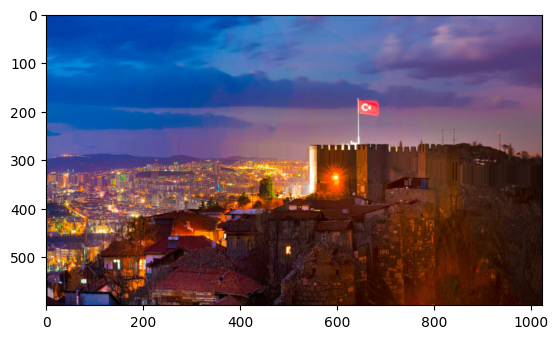

In [41]:
height = 600
width = 1024

resized_img7 = MySeamCarvingUpdated(img_torch4, width, height)

print("Resized Image Shape:", resized_img7.shape)

resized_img7_np = kornia.utils.tensor_to_image(resized_img7)

resized_img7_np = (resized_img7_np * 255.0).astype(np.uint8)

plt.imshow(resized_img7_np)
plt.show()

Resized Image Shape: torch.Size([1, 3, 564, 1074])


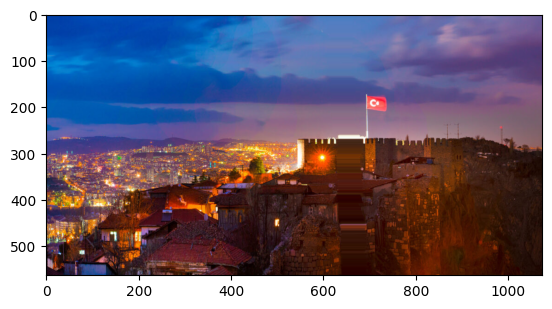

In [42]:
height = 564
width = 1074

resized_img8 = MySeamCarvingUpdated(img_torch4, width, height)

print("Resized Image Shape:", resized_img8.shape)

resized_img8_np = kornia.utils.tensor_to_image(resized_img8)

resized_img8_np = (resized_img8_np * 255.0).astype(np.uint8)

plt.imshow(resized_img8_np)
plt.show()

Testing on both increasing and decreasing the dimensions

Resized Image Shape: torch.Size([1, 3, 600, 800])


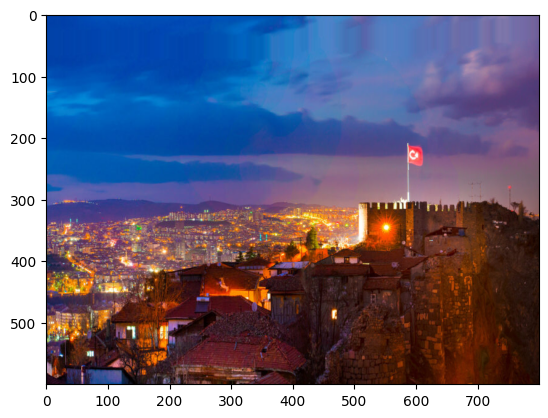

In [43]:
height = 600
width = 800

resized_img9 = MySeamCarvingUpdated(img_torch4, width, height)

print("Resized Image Shape:", resized_img9.shape)

resized_img9_np = kornia.utils.tensor_to_image(resized_img9)

resized_img9_np = (resized_img9_np * 255.0).astype(np.uint8)

plt.imshow(resized_img9_np)
plt.show()